# TP : Proximal coordinate descent method on regression models

#### Authors: R. Gower, A. Gramfort

## Aim

The aim of this material is to code 
- proximal coordinate descent

for 
- Lasso / L1 linear regression
- non-negative least squares (NNLS)

models.

The proximal operators we will use are the 
- L1 penalization
- indicator function of $\mathbb{R}_+$

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 22th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 16 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [2]:
# Change here using YOUR first and last names
fn1 = "xiao"
ln1 = "pan"
fn2 = "yunzhi"
ln2 = "wu"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_cd", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_cd_pan_xiao_and_wu_yunzhi.ipynb


In [3]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse positive vectors and simulating data

### Getting sparse coefficients

In [4]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

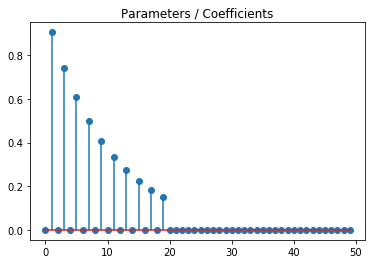

In [5]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (idx % 2) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [6]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

## Proximal operators and Solver


We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Lasso penalization, where $g(x) = s \|x\|_1$
- Indicator function of $\mathbb{R}^n_+$, where $g(x) = i_{x \in \mathbb{R}_+^n}(\cdot)$

where $s \geq 0$ is a regularization parameter.

We want to minimize:
$$
\arg\min_x F(x)
$$
with
$$
 F(x) = \frac{1}{2} \|b - Ax\|^2 + g(x)
$$

## Questions

- Code a function that computes $g(x)$ and $\text{prox}_g(x)$ for in both cases
- Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions.
- Starting from the code provided in the notebook presented during the coordinate descent course as well as the code below, implement a proximal coordinate method for both penalties.
- Evaluate qualitatively the convergence when varying the conditioning of the problem.
- Bonus: Try to show that coordinate is much less affected by bad conditioning than proximal gradient descent.

### You are expected to implement the smart residuals updates !

### You are very welcome to reuse everything you did for TP1 !

### Question 1
   - Code a function that computes  g(x) and  proxg(x) for in both cases 


In [7]:
# proximate for each coordinate
def proxi(xi,func,s,t=1.):
    if func == "lasso":
        y = 0
        if xi > s*t:
            y = xi-s*t
        elif xi < -s*t:
            y = xi+s*t
        return y
    if func == "indicator":
        if xi >= 0:
            return xi
        else:
            return 0

# proximate
def prox(x, func, s, t=1.):
    p = []
    for i in range(x.shape[0]):
        p.append(proxi(x[i], func, s, t=t))
    return p

# g
def g(x, func, s):
    if func == "lasso":
        return s * np.linalg.norm(x, ord=1)
    if func == "indicator":
        if np.all(x >= 0):
            return 0
        else:
            return 1e5
    

### Question 2
   - Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions.

### Proof

For the coordinate descent, we update only one dimension.
In each iteration, the objective function is
$$
\arg\min_z f(x) + \triangledown_i f(x)*(z_i-x_i) +\frac{1}{2t}(z_i-x_i)^2 + g_i(z_i)
$$
In our cases, Non-smooth part is separable:
- for lasso penalty,
$g(x)=\sum_i s | x_i |$, $g_i(x_i)= s | x_i |$ <br><br>

- for indicator penalty,
$g(x)=i_{x \in \mathbb{R}_+^n} = \sum_i i_{x_{i} \in \mathbb{R}_+}$, $g_i(x_i)= i_{x_{i} \in \mathbb{R}_+}$ <br\>

Moreover,
$\triangledown f = A^T (Ax-b)$ is Lipschitz continuous: 
$$ \forall x, y \in R^p, ~ \|A^TAx-A^TAy\|\leq Max(Eigenvalue(A^TA))\|x-y\|$$
According to Richtarik and Tackac Proposition, the proximal coordinate descent method converges to the minimum.


### Question 3
- implement a proximal coordinate method for both penalties.

In [8]:
def cd_linreg(x0, A, b, g_,  s=0., n_iter=50,
              x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm

    Minimize :
    
    1/2 ||b−Ax||^2 + s * g(x)
    
    with coordinate descent.
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape
    
    #Li = np.sum(A * A, axis=0)
    L = A.T.dot(A)
    ATA = A.T.dot(A)
    ATb = A.T.dot(b)
    grad = ATA.dot(x) - ATb
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective

    obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x,g_,s)
    objectives.append(obj)

    if verbose:
        print("Launching Coordinate Descent solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    

    for k in range(n_iter + 1):
        i = k % n_features
        x_new[i] = proxi((x[i] - grad[i]/L[i,i]), g_, s, t=1/L[i,i])

        grad = grad - ATA[:,i]*x[i] + ATA[:,i]*x_new[i] 
        x[i] = x_new[i]
        
        obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, g_, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

### Question 4
 - Evaluate qualitatively the convergence when varying the conditioning of the problem.

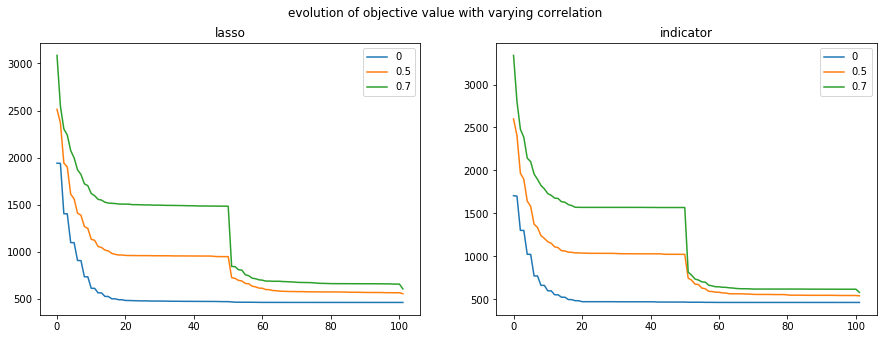

In [35]:
x0 = np.zeros(n_features)
corrs = [0, 0.5,0.7]
plt.figure(figsize=(15,5))
plt.suptitle("evolution of objective value with varying correlation")
plt.subplot(121)
plt.title("lasso")
for corr in corrs:
    A,b = simu_linreg(coefs, n_samples=1000, corr=corr)
    x1, obj1, err1 = cd_linreg(x0, A, b, "lasso",  s=0.5, n_iter=100,
              x_true=coefs, verbose=0)
    plt.plot(obj1, label=corr)
plt.legend()

plt.subplot(122)
plt.title("indicator")
for corr in corrs:
    A,b = simu_linreg(coefs, n_samples=1000, corr=corr)
    x2, obj2, err2 = cd_linreg(x0, A, b, "indicator",  s=0.5, n_iter=100,
              x_true=coefs, verbose=0)
    plt.plot(obj2, label=corr)
plt.legend()

plt.show()

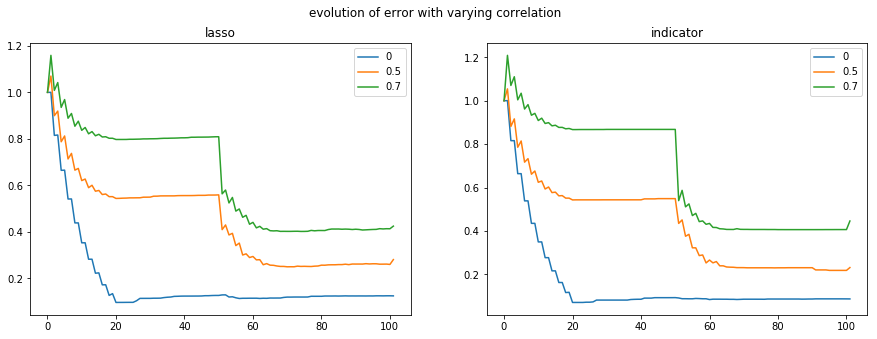

In [34]:
x0 = np.zeros(n_features)
corrs = [0, 0.5,0.7]
plt.figure(figsize=(15,5))
plt.suptitle("evolution of error with varying correlation")
plt.subplot(121)
plt.title("lasso")
for corr in corrs:
    A,b = simu_linreg(coefs, n_samples=1000, corr=corr)
    x1, obj1, err1 = cd_linreg(x0, A, b, "lasso",  s=0.5, n_iter=100,
              x_true=coefs, verbose=0)
    plt.plot(err1, label=corr)
plt.legend()

plt.subplot(122)
plt.title("indicator")
for corr in corrs:
    A,b = simu_linreg(coefs, n_samples=1000, corr=corr)
    x2, obj2, err2 = cd_linreg(x0, A, b, "indicator",  s=0.5, n_iter=100,
              x_true=coefs, verbose=0)
    plt.plot(err2, label=corr)
plt.legend()

plt.show()

### Observations
* At each iteration, the objective value never reincrease.
* When the correlation is zero, there is only one "step" in the graph. The objective function reached the minimum at the 20th iteration, which accords to the 20 non-null coefficients(features).
* With correlation increases, the convergency becomes slower.
* When the correlation nonzero, the error to true coefficient jumps in each iteration in a cycle.

### Analysis
* At each iteration, the objective function should achieve a minimum with respect to $x_i$, so after each iteration, the objective value never reincrease.
* If the coefficients are independent, we can reach the minimum in the first cycle of coordinate descent. This is easy to understand, since the coefficients are independent, once they reach the $argmin_{x_i}F(x)$, the change of coefficients on other coordinates will not affect it. Thus, without correlation between coefficients, we will not observe more than one "step" on the graph. On the other hand, when the coefficients are correlated, even though in one cycle the coordinate $x_i$ arrives at its minimizer under given $x_{-i}$, it becomes no longer the minimizer when the other coordinates change in the following iterration. Thus, in the next cycle, $x_i$ can move to a new minimizer and decreases the objective function, and we can observe several "steps".
* The proximal coordinate descent works better when the coefficients are more independent.
* Similar to the first analysis, the correlated coefficients can affect each other. Thus, the next iteration may increase the error.

### Question 5 (Bonus)
 - Try to show that coordinate is much less affected by bad conditioning than proximal gradient descent.

In [14]:
def gd_linreg(x0, A, b, g_, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape
    ATA = A.T.dot(A)
    ATb = A.T.dot(b)
    grad = ATA.dot(x) - ATb
    L = np.linalg.norm(A.T.dot(A),2)
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x,g_,s)
    objectives.append(obj)
    grad = ATA.dot(x) - ATb
    if verbose:
        print("Lauching solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        x_new = prox(x - grad*1./L, g_, s)
        x = x_new
        obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x,g_,s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        grad = ATA.dot(x) - ATb
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

Lauching solver...
   it    |   obj    |   err   
       0 | 1.73e+03 | 9.95e-01
      10 | 1.72e+03 | 9.91e-01
      20 | 1.72e+03 | 9.91e-01
      30 | 1.72e+03 | 9.91e-01
      40 | 1.72e+03 | 9.91e-01
      50 | 1.72e+03 | 9.91e-01


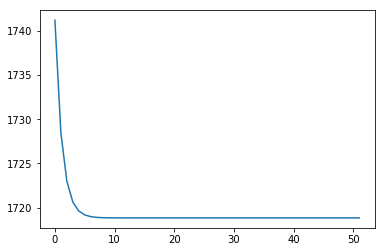

In [53]:
A,b = simu_linreg(coefs, n_samples=1000, corr=0.2)
x, obj, err = gd_linreg(np.zeros(n_features), A, b, "lasso",  s=0.5, n_iter=50, x_true=coefs)
plt.plot(obj)

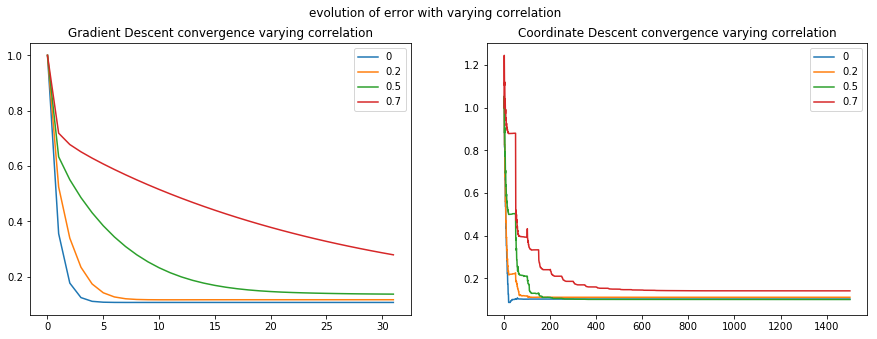

In [39]:
x0 = np.zeros(n_features)
corrs = [0,0.2,0.5,0.7]
plt.figure(figsize=(15,5))
plt.suptitle("Evolution of error with varying correlation")
plt.subplot(121)
plt.title("Gradient Descent convergence varying correlation")
for corr in corrs:
    A,b = simu_linreg(coefs, n_samples=1000, corr=corr)
    x_g, obj_g, err_g = gd_linreg(x0, A,b,g_="indicator", s=0.5, n_iter=30, x_true=coefs, verbose=False)
    plt.plot(err_g, label=corr)
plt.legend()

plt.subplot(122)
plt.title("Coordinate Descent convergence varying correlation")
for corr in corrs:
    A,b = simu_linreg(coefs, n_samples=1000, corr=corr)
    x1, obj1, err1 = cd_linreg(x0, A, b, "indicator",  s=0.5, n_iter=30*n_features, x_true=coefs, verbose=0)
    plt.plot(err1, label=corr)
plt.legend()

plt.show()

### Remark:
   - Because coordinate descent algorithm computes only one coordinate at each iteration while gradient descent computes all features at each iteration, it is naturual that we compare the convergence rate as:
       - one gradient descent VS n_features coordinate descent
   - To observe the convergence rate, we plot the error.
 
### Observations
   - As the correlation grows(condition number grows):
        - the gradient descend algorithm converge slower significantly
        - whereas the coordinate descend convergence rate is not affected much.
   - When the correlation of the features is 0, the two algorithms performs almost equally(both converges very fast)
   - In the first iteration the two algorithms converges similary, since the step length are the same: $\frac{1}{max(L_i)}$

### Analysis
#### 1 The relation between condition number and correlation of the features
1) The condition number of A is the ratio C of the largest to smallest singular value.

2) If the features are highly correlated, there might be some very small sigular values in A. Then C may be very large.

3) So the condition number becomes bigger and bigger implies the correlation between features become stronger and stronger.
   
#### 2 What the Lipschitz constant means intuitively
 1) The Lipschitz constant denotes the steep degree of a function:
   - L large: the function is steep
   - L small: the function is flat

#### 3 Difference in Lipschitz constant in both algorithms
 1) The Lipschitz constant at every coordinate is $L_i = A_i^T A_i$ , the 'general' Lipschitz constant is $L = max(L_i)$
 
 2) The step size of gradient descent algorithm is the inverse of 'general' Lipschitz constant
   -  L is thus bounded by the largest singular value of A.
   - The step size of gradient descent algorithm is restricted to a relatively small number

3) The step size of coordinate descent algorithm varies by the coordinate, according to the coordinate Lipschitz constant $L_i$:
   - When $L_i$ small, the step size is large (step size bigger for the flater dimension)
   - When $L_i$ large, the step size is small (step size smaller for the steeper dimension)

#### 4 Conclusion: coordinate descent is much less affected by bad conditioning than proximal gradient descent.
 1) When the correlation of all the features are close to 0, the Lipschitz constant at every coordinate are very close to each other, thus the condition number is close to 1. Intuitively, this function is even in each coordinates: in every dimension, the steepness of the function are almost the same. In this case, the step size of the gradient descent algorithm is reasonable for all dimensions, so the two algorithms performs equally.

 2) When the correlation of all the features are very large, even close to 1, the Lipschitz constant at some coordinate may be very close to zero, thus the condition number is very big. Intuitively, this function is 'distorted': in some dimension, it is very steep while in other dimension it may be very flat. However, the step size of the gradient descent algorithm is bounded to a small value, which may converge slowly in the relatively flat dimensions. So in this case, coordinate descent performs better than gradiant descent (converges faster).

